In [1]:
import matplotlib
import pylab as plt
import astropy
import astropy.units as u
from astropy.io import fits
from astropy import constants as const
import numpy as np
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from scipy.interpolate import interp1d
import sys

In [2]:
#sys.path.insert(0, '/Users/dstn/speclite')

In [3]:
import speclite.filters

In [4]:
# Medium-band filters -- we're going to assume constant-throughput, top-hat filters.
# This is the constant throughput
mb_eff = 0.95
# These are the edges of the filters -- so MB0 is 3750-4006 A, MB1 is 4006-4265, etc.
mb_limits = [3750, 4006, 4265, 4519, 4779, 5036, 5297, 5507]

In [5]:
hrs_per_night = 10.

In [6]:
# We scale the sky spectrum by a correction factor to bring u-band to 22.0 mag/arcsec^2,
# corresponding to SDSS experience.
sky_scaling = 10.**((22.0 - 21.80) / -2.5)
sky_scaling

0.8317637711026715

In [48]:
# Seeing and effective telescope diameters

seeings = {
    'CFHT': 0.8,
    'HSC': 0.8,
    'LSST': 1.0,
    'DECam': 1.2,
    'Spec-S5': 1.2,
}

tel_diams = {
    'CFHT': 3.5 * u.m,
    'HSC': 8.2 * u.m, ##????? effective area must be smaller
    'LSST': 6.423 * u.m, # https://smtn-002.lsst.io/
    'DECam': 3.51 * u.m, # DECam ETC spreadsheet, 9.70 sq m
    'Spec-S5': 6.0 * u.m, ##????? effective area must be smaller
}

In [7]:
pixscales = {
    'CFHT': 0.185,
    'HSC': 0.168,
    'LSST': 0.2,
    'DECam': 0.262,
    'Spec-S5': 0.16,
}

# Number of pixels in the camera
cam_pix = {
    'CFHT': 40 * 2048 * 4612,
    'DECam': 60 * 2048 * 4096,
    'HSC': 104 * 2048 * 4096,  # effective number of chips given vignetting etc?
    'LSST': 189 * 4096 * 4096,
    'Spec-S5': 64 * 6144 * 6160, # Teledyne/e2v
}

# Effective area per exposure
cam_sqdeg = {}
for k,v in cam_pix.items():
    cam_sqdeg[k] = v * (pixscales[k]/3600.)**2
cam_sqdeg

{'CFHT': 0.9977407209876543,
 'DECam': 2.6658685534814817,
 'HSC': 1.899926505244445,
 'LSST': 9.786709333333334,
 'Spec-S5': 4.784613451851853}

In [8]:
# Assumed galaxy size (Gaussian sigma), in arcsec
gal_size = 0.35 # arcsec

# Target S/N of source detection
snr = 6.

In [9]:
#filters1 = speclite.filters.load_filters(
#    #'cfht_megacam-u', 'cfht_megacam-g', 
#    'lsst2016-u', 'lsst2016-g', 'lsst2016-r', 'lsst2016-i', 'lsst2016-z', 'lsst2016-y',
#    #'decamDR1-g', 'suprime-IB427',
#)
filters = speclite.filters.load_filters(
    'lsst2023-u', 'lsst2023-g', #'lsst2023-r',# 'lsst2023-i', 'lsst2023-z', 'lsst2023-y',
)

In [10]:
def read_uves_spectrum(fn):
    hdu = fits.open(fn)[0]
    hdr = hdu.header
    sky_flux = hdu.data
    crpix, crval, cdelt = hdr['CRPIX1'], hdr['CRVAL1'], hdr['CDELT1']
    sky_pix = (1 + np.arange(len(sky_flux)))
    sky_wave = crval + (sky_pix - crpix) * cdelt
    return sky_wave, sky_flux

In [11]:
wave1,flux1 = read_uves_spectrum('fluxed_sky_346.fits')
wave2,flux2 = read_uves_spectrum('fluxed_sky_437.fits')
wave3,flux3 = read_uves_spectrum('fluxed_sky_580L.fits')

In [12]:
split12 = 3760.
split23 = 4850.
I1 = (wave1 < split12)
I2 = (wave2 >= split12) * (wave2 < split23)
I3 = (wave3 >= split23)
sky_wave = np.hstack((wave1[I1], wave2[I2], wave3[I3]))
sky_flux = np.hstack((flux1[I1], flux2[I2], flux3[I3]))

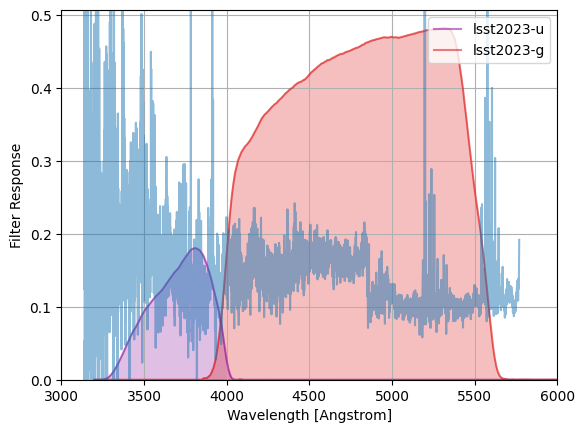

In [13]:
speclite.filters.plot_filters(filters)
plt.plot(sky_wave, gaussian_filter1d(sky_flux, 5), alpha=0.5);
plt.xlim(3000, 6000);

In [14]:
def read_lsst_throughput(fn, basedir='/Users/dstn/lsst-throughputs/baseline', wave_factor = 10.,
                        assert_2_words=True):
    fullfn = os.path.join(basedir, fn)
    vals = []
    for line in open(fullfn).readlines():
        line = line.strip()
        if line.startswith('#'):
            continue
        words = line.split()
        if len(words) == 0:
            continue
        if assert_2_words:
            assert(len(words) == 2)
        #print(words)
        vals.append((float(words[0]), float(words[1])))
    vals = np.array(vals)
    # Bizarro, subaru m1 file is not sorted!!
    I = np.argsort(vals[:,0])
    vals = vals[I,:]
    
    # Wavelength (nm->A), throughput
    return vals[:,0] * wave_factor, vals[:,1]

In [15]:
# 1A wavelength grid over the range we care about
wavegrid = np.arange(3000., 5700+1, 1.0) #7000+1, 1.0)

In [16]:
MB = []
for lo,hi in zip(mb_limits, mb_limits[1:]):
    f = interp1d(wavegrid, mb_eff * (wavegrid >= lo) * (wavegrid < hi), bounds_error=False, fill_value=0.)
    MB.append(f)

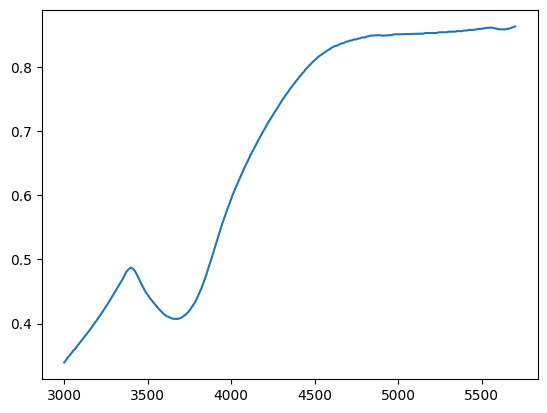

In [17]:
pieces = ['detector', 'lens1', 'lens2', 'lens3', 'm1', 'm2', 'm3']
thru = np.ones(len(wavegrid))
thru_pieces = {}
for p in pieces:
    pf = interp1d(*read_lsst_throughput(p+'.dat'))
    thru_pieces[p] = pf
    pf = pf(wavegrid)
    thru *= pf
lsst_thru = interp1d(wavegrid, thru)

# 1.0 airmasses
atm10 = interp1d(*read_lsst_throughput('atmos_10.dat'))
# 1.2 airmasses
atm12 = interp1d(*read_lsst_throughput('atmos_std.dat'))

# LSST's hardware_F = thru * filter_F
#        total_F = hardware_F * atmos_std

lsst_ccd = thru_pieces['detector']
plt.plot(wavegrid, lsst_ccd(wavegrid));

In [18]:
# Mirror is reported in %, not throughput.
pieces = [('qe_ccd_HSC.txt', 1., 1.),
          ('subaru_m1_r_20221013.txt', 10., 0.01),
          #('subaru_m1_r_20180129.txt', 10., 0.01),
          ('throughput_popt2.txt', 1., 1.),
          ('throughput_win.txt', 1., 1.),
         ]
hsc_thru = np.ones(len(wavegrid))
for p,wf,tf in pieces:
    w,t = read_lsst_throughput(p, basedir='hsc', wave_factor=1, assert_2_words=False)
    #plt.plot(w*wf,t*tf)
    #plt.show()
    
    pf = interp1d(w*wf, t*tf, 
                   bounds_error=False, fill_value=0.)
    hsc_thru *= pf(wavegrid)
    
hsc_thru = interp1d(wavegrid, hsc_thru)

#hsc_g = interp1d(*read_lsst_throughput('hsc_g_v2018.dat', basedir='hsc', wave_factor=1),
#                bounds_error=False, fill_value=0.)

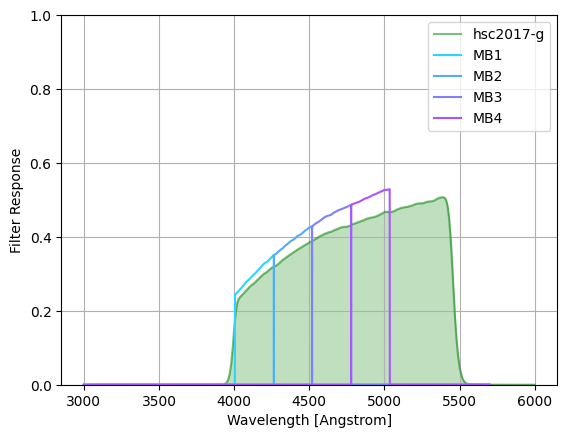

In [19]:
speclite.filters.plot_filters(
    speclite.filters.load_filters('hsc2017-g'))

hsc_atm = atm12

cm = matplotlib.cm.cool
for i,mb in enumerate(MB):
    if i < 1 or i > 4:
        continue
    plt.plot(wavegrid, hsc_thru(wavegrid) * hsc_atm(wavegrid) * mb(wavegrid),
             color=cm(i/6), label='MB%i'%i)
plt.legend();
#plt.plot(wavegrid, hsc_thru(wavegrid) * atm12(wavegrid) * 0.9)
#plt.plot(wavegrid, hsc_g(wavegrid))
plt.ylim(0,1);

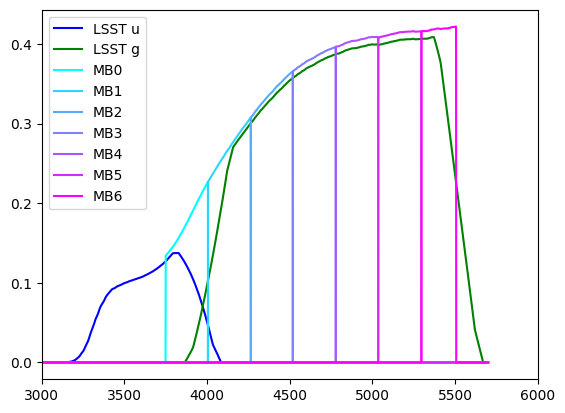

In [20]:
#speclite.filters.plot_filters(filters)
for f in ['u','g']:
    plt.plot(wavegrid, lsst_thru(wavegrid)*atm12(wavegrid) *
        interp1d(*read_lsst_throughput('filter_%s.dat'%f))(wavegrid), label='LSST %s'%f,
            color={'u':'b'}.get(f,f))

cm = matplotlib.cm.cool
for i,mb in enumerate(MB):
    plt.plot(wavegrid, lsst_thru(wavegrid) * atm12(wavegrid) * mb(wavegrid),
             color=cm(i/6), label='MB%i'%i)
plt.legend();
plt.xlim(3000, 6000);

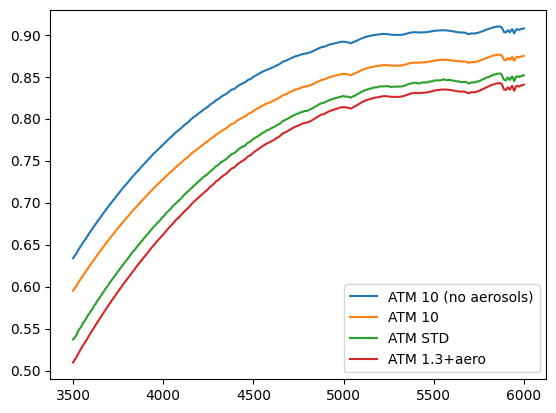

In [21]:
hwg = interp1d(*read_lsst_throughput('hardware_g.dat'))
totg = interp1d(*read_lsst_throughput('total_g.dat'))
atm = interp1d(*read_lsst_throughput('atmos_std.dat'))
atm10 = interp1d(*read_lsst_throughput('atmos_10.dat'))
filtg = interp1d(*read_lsst_throughput('filter_g.dat'))

atm10_noaero = interp1d(*read_lsst_throughput('atmos_10.dat', basedir='/Users/dstn/lsst-throughputs/atmos'))
atm12_hi = interp1d(*read_lsst_throughput('atmos_12_hiwater.dat', basedir='/Users/dstn/lsst-throughputs/atmos'))
atm12_lo = interp1d(*read_lsst_throughput('atmos_12_lowater.dat', basedir='/Users/dstn/lsst-throughputs/atmos'))

# Water doesn't make a difference for us in the blue -- but aerosols do!
atm12_hi_a = interp1d(*read_lsst_throughput('atmos_12_hiwater_aerosol.dat', basedir='/Users/dstn/lsst-throughputs/atmos'))
atm12_lo_a = interp1d(*read_lsst_throughput('atmos_12_lowater_aerosol.dat', basedir='/Users/dstn/lsst-throughputs/atmos'))

atm13_a = interp1d(*read_lsst_throughput('atmos_13_aerosol.dat', basedir='/Users/dstn/lsst-throughputs/atmos'))

lsst_atm = atm

wave = np.linspace(3500, 6000, 500)
#plt.plot(wave, atm(wave) * hwg(wave), label='ATMO * HW g', lw=5, alpha=0.1)
#plt.plot(wave, hwg(wave), label='HW g')
#plt.plot(wave, filtg(wave), label='Filt g')
#plt.plot(wave, totg(wave), label='Tot g')
plt.plot(wave, atm10_noaero(wave), label='ATM 10 (no aerosols)')
plt.plot(wave, atm10(wave), label='ATM 10')
plt.plot(wave, atm(wave), label='ATM STD')
plt.plot(wave, atm13_a(wave), label='ATM 1.3+aero')
#plt.plot(wave, atm12_hi(wave), label='ATM 12 (high water)')
#plt.plot(wave, atm12_lo(wave), label='ATM 12 (low water)')
#plt.plot(wave, atm12_hi_a(wave), label='ATM 12 (high water + aero)')
#plt.plot(wave, atm12_lo_a(wave), label='ATM 12 (low water + aero)')
#plt.plot(wave, thru(wave) * filtg(wave), label='throughput', lw=5, alpha=0.1);
plt.legend();

In [22]:
# The UVES sky fluxes are in 1e-16 erg/(s A cm^2 arcs^2)
sky_wave_u = sky_wave * u.Angstrom
# per arcsec^2
sky_flux_u = sky_flux * 1e-16 * u.erg / (u.cm**2 * u.s * u.Angstrom)

In [23]:
uves_sky_wave = sky_wave_u
uves_sky_flux = sky_flux_u

In [24]:
# Read CFHT data tables...
def read_table(fn, wavelengths, sep=None, wave_scale=10., trans_scale=0.01):
    f = open(fn)
    qe = []
    for line in f.readlines():
        words = line.strip().split(sep=sep)
        #if len(words) != 2:
        #    continue
        try:
            f1,f2 = float(words[0]), float(words[1])
        except:
            continue
        qe.append([wave_scale * f1, trans_scale * f2])
    qe = np.array(qe)
    if wavelengths is None:
        return qe
    qe_wave = qe[:,0] * u.Angstrom
    qe_frac = qe[:,1]
    qe = np.interp(wavelengths, qe_wave, qe_frac)
    return qe

In [25]:
#decam_sky = read_table('spec-sky.dat', sky_wave_u, wave_scale=1., trans_scale=1.)
decam_sky = read_table('spec-sky-cut.dat', None, wave_scale=1., trans_scale=1.)
decam_wave_u = decam_sky[:,0] * u.Angstrom
decam_flux_u = decam_sky[:,1] * 1e-17 * sky_flux_u.unit
#
decam_flux_u *= sky_scaling
#
decam_flux_u.unit

Unit("erg / (Angstrom cm2 s)")

In [26]:
sky_wave_u = decam_wave_u
sky_flux_u = decam_flux_u

In [27]:
# From CFHT - QE_camera.dat
qe = read_table('QE_camera.dat', sky_wave_u)
# Optics_TR.dat
optics = read_table('Optics_TR.dat', sky_wave_u)
# Mirror - Al_coating.dat
mirror = read_table('Al_coating.dat', sky_wave_u)

cfht_thru = qe * optics * mirror

# Filters - 
u_filt = read_table('cfh9302.dat', sky_wave_u, sep=',')
g_filt = read_table('cfh9402.dat', sky_wave_u, sep=',')
cahk_filt = read_table('cfh9303.dat', sky_wave_u, sep=',')

# Fake a flat-topped M4112 filter.
#m4112_filt = 0.92 * (sky_wave_u >= 4004*u.Angstrom) * (sky_wave_u <= 4262.8*u.Angstrom)

In [28]:
#plt.plot(sky_wave_u, qe, label='CCD QE');
#plt.plot(sky_wave_u, optics, label='Optics');
#plt.plot(sky_wave_u, mirror, label='Mirror');
#plt.plot(sky_wave_u, u_filt, label='u filter');
#plt.plot(sky_wave_u, g_filt, label='g filter');
#plt.plot(sky_wave_u, cahk_filt, label='CaH+K filter');
#plt.plot(sky_wave_u, m4112_filt, label='M4112 filter (fake)');

u_tot = cfht_thru * u_filt
g_tot = cfht_thru * g_filt
cahk_tot = cfht_thru * cahk_filt
#m4112_tot = qe * optics * mirror * m4112_filt

#plt.plot(sky_wave_u, u_tot, label='u total');
#plt.plot(sky_wave_u, g_tot, label='g total');
#plt.plot(sky_wave_u, m4112_tot, label='M4112 total (fake)');
#plt.plot(sky_wave_u, cahk_tot, label='CaH+K total');
#plt.xlabel('Wavelength (A)')
#plt.ylabel('Transmission')
#plt.legend();

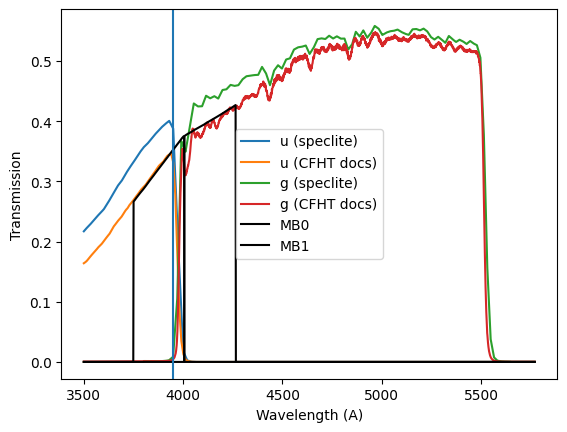

In [29]:
# The transmission curves I'm getting for CFHT are in line with what SpecLite is giving,
# *IF* I use the LSST 1.0-airmass, no-aerosols atmosphere!
# Speclite claims to include attenuation from 1.25 airmasses

cfht_filters = speclite.filters.load_filters(
  'cfht_megacam-u', 'cfht_megacam-g')

#atmo = atm10_noaero(sky_wave_u)
atmo = atm(sky_wave_u)
#atmo = np.sqrt(atm(sky_wave_u) * atm13_a(sky_wave_u))
#atmo = atm13_a(sky_wave_u)

cfht_atm = atmo

plt.plot(sky_wave_u, cfht_filters[0].interpolator(sky_wave_u), label='u (speclite)');
plt.plot(sky_wave_u, cfht_thru * u_filt * atmo, label='u (CFHT docs)');
plt.plot(sky_wave_u, cfht_filters[1].interpolator(sky_wave_u), label='g (speclite)');
plt.plot(sky_wave_u, cfht_thru * g_filt * atmo, label='g (CFHT docs)');

plt.plot(sky_wave_u, cfht_thru * MB[0](sky_wave_u) * atmo, color='k', label='MB0');
plt.plot(sky_wave_u, cfht_thru * MB[1](sky_wave_u) * atmo, color='k', label='MB1');

cfht_u_filt = interp1d(sky_wave_u, u_filt, bounds_error=False, fill_value=0.)
cfht_cahk_filt = interp1d(sky_wave_u, cahk_filt, bounds_error=False, fill_value=0.)

plt.xlabel('Wavelength (A)')
plt.ylabel('Transmission')
plt.legend();
plt.axvline(3950);

In [30]:
cfht_thru = interp1d(sky_wave_u, cfht_thru, bounds_error=False, fill_value=0.)
cfht_atm = interp1d(sky_wave_u, cfht_atm, bounds_error=False, fill_value=0.)

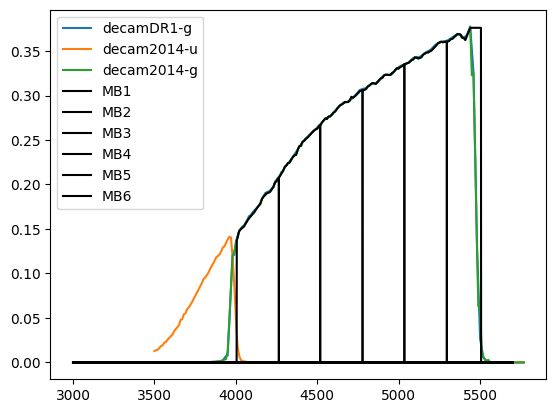

In [31]:
decam_filters = speclite.filters.load_filters('decamDR1-g', 'decam2014-u', 'decam2014-g')#, 'decam2014-r')
for f in decam_filters:
    plt.plot(sky_wave_u, f.interpolator(sky_wave_u), label=f.name)

decam_filters = speclite.filters.load_filters('decam2014-u', 'decam2014-g')#, 'decam2014-r')
decam_thru = np.maximum(*[f.interpolator(sky_wave_u) for f in decam_filters])

decam_g = decam_filters[1].interpolator

# Correct for the assumed 95% MB throughput
decam_thru /= mb_eff

# The g-band transmission drops off before the r-band picks up -- assume the throughput would actually
# be flat at the max g value.  This avoids suppressing the red end of MB6.
i = np.argmax(decam_thru)
decam_thru[i:] = decam_thru[i]

decam_thru = interp1d(np.append([3000., 3500.], sky_wave_u.value), np.append([0., 0.], decam_thru))

# This decam_thru already has atmospheric extinction
decam_atm = lambda x: np.ones(len(x))

for i,mb in enumerate(MB):
    if i < 1:
        continue
    plt.plot(wavegrid, decam_thru(wavegrid) * decam_atm(wavegrid) * mb(wavegrid),
             color='k', label='MB%i'%i)

plt.legend();

In [32]:
# Throughputs vs DECam g... not convinced this tells us anything useful -- isn't it just measuring the relative
# height of the g filter in the MB range vs the whole g filter???

dg = decam_g(wavegrid)
I = np.flatnonzero(dg > 0.1)
gthru = np.mean(dg[I])

for i,mb in enumerate(MB):
    if i < 1:
        continue
    f = decam_thru(wavegrid) * decam_atm(wavegrid) * mb(wavegrid)
    I = np.flatnonzero(f > 0.1)
    thru = np.mean(f[I])
    print('MB%i: %.3f vs g' % (i, thru/gthru))

MB1: 0.625 vs g
MB2: 0.858 vs g
MB3: 1.029 vs g
MB4: 1.144 vs g
MB5: 1.244 vs g
MB6: 1.319 vs g


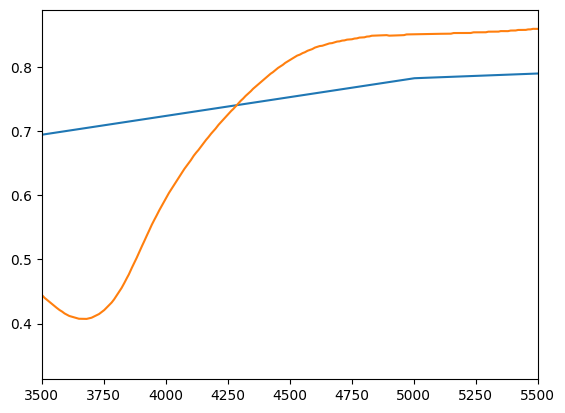

In [33]:
plt.plot(qe)
plt.plot(wavegrid, lsst_ccd(wavegrid))
plt.xlim(3500, 5500);

In [34]:
# Spec-S5 -- could use the LSST CCD QE curve, which is in-line with the datasheet "typical QE" curve for the
# deep-depletion silicon, astro broadband, for Teledyne/e2v CCD231-C6.

In [35]:
pieces = ['lens1', 'lens2', 'lens3', 'm1', 'm2', 'm3']
thru = np.ones(len(wavegrid))
thru_pieces = {}
for p in pieces:
    pf = interp1d(*read_lsst_throughput(p+'.dat', basedir='lsst-old'))
    thru_pieces[p] = pf
    pf = pf(wavegrid)
    thru *= pf
thru *= lsst_ccd(wavegrid)
specs5_thru = interp1d(wavegrid, thru)

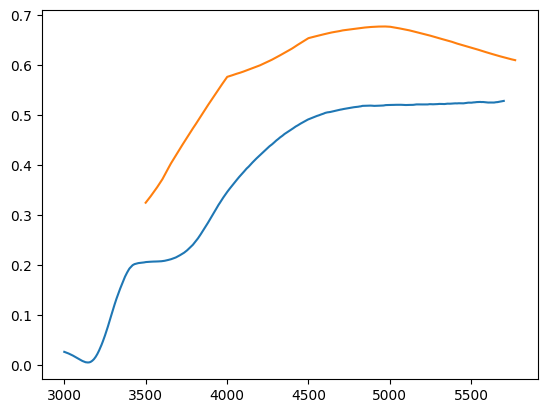

In [36]:
plt.plot(wavegrid, specs5_thru(wavegrid));
plt.plot(sky_wave_u, cfht_thru(sky_wave_u));

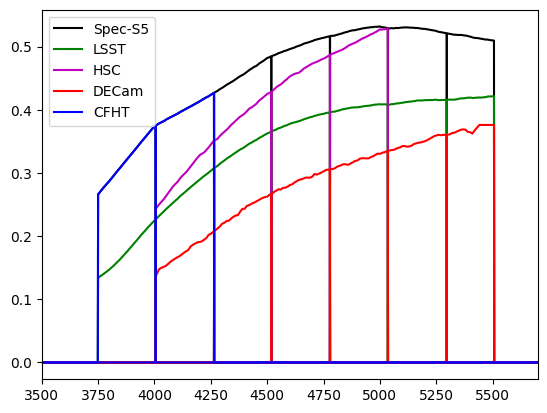

In [37]:
combos = []

def thrufunc(w,tel,atm,mb):
    f = interp1d(wavegrid, tel(wavegrid)*atm(wavegrid)*mb(wavegrid), bounds_error=False, fill_value=0.)
    return f


for i,mb in enumerate(MB):
    kwa = {}
    if i == 0:
        kwa.update(label='Spec-S5')
    plt.plot(wavegrid, cfht_thru(wavegrid) * cfht_atm(wavegrid) * mb(wavegrid),
             color='k', **kwa)
    combos.append(('Spec-S5', i, thrufunc(wavegrid, cfht_thru, cfht_atm, mb)))#lambda x: cfht_thru(x) * cfht_atm(x) * mb(x)))

for i,mb in enumerate(MB):
    kwa = {}
    if i == 0:
        kwa.update(label='LSST')
    plt.plot(wavegrid, lsst_thru(wavegrid) * lsst_atm(wavegrid) * mb(wavegrid),
             color='g', **kwa)
    combos.append(('LSST', i, thrufunc(wavegrid, lsst_thru, lsst_atm, mb)))##lambda x: lsst_thru(x) * lsst_atm(x) * mb(x)))

for i,mb in enumerate(MB):
    if i < 1 or i > 4:
        continue
    kwa = {}
    if i == 1:
        kwa.update(label='HSC')
    plt.plot(wavegrid, hsc_thru(wavegrid) * hsc_atm(wavegrid) * mb(wavegrid),
             color='m', **kwa)
    combos.append(('HSC', i, thrufunc(wavegrid, hsc_thru, hsc_atm, mb)))#lambda x: hsc_thru(x) * hsc_atm(x) * mb(x)))

for i,mb in enumerate(MB):
    if i < 1:
        continue
    kwa = {}
    if i == 1:
        kwa.update(label='DECam')
    plt.plot(wavegrid, decam_thru(wavegrid) * decam_atm(wavegrid) * mb(wavegrid),
             color='r', **kwa)
    combos.append(('DECam', i, thrufunc(wavegrid, decam_thru, decam_atm, mb)))#lambda x: decam_thru(x) * decam_atm(x) * mb(x)))


plt.plot(wavegrid, cfht_thru(wavegrid) * MB[0](wavegrid) * cfht_atm(wavegrid), color='b', label='CFHT');
plt.plot(wavegrid, cfht_thru(wavegrid) * MB[1](wavegrid) * cfht_atm(wavegrid), color='b');
combos.append(('CFHT', 0, thrufunc(wavegrid, cfht_thru, cfht_atm, MB[0]))) #lambda x: cfht_thru(x) * cfht_atm(x) * MB[0](x)))
combos.append(('CFHT', 1, thrufunc(wavegrid, cfht_thru, cfht_atm, MB[1]))) #lambda x: cfht_thru(x) * cfht_atm(x) * MB[1](x)))
combos.append(('CFHT', 7, thrufunc(wavegrid, cfht_thru, cfht_atm, cfht_u_filt))) #lambda x: cfht_thru(x) * cfht_atm(x) * MB[1](x)))
combos.append(('CFHT', 8, thrufunc(wavegrid, cfht_thru, cfht_atm, cfht_cahk_filt))) #lambda x: cfht_thru(x) * cfht_atm(x) * MB[1](x)))

plt.legend();
plt.xlim(3500, 5700);
plt.savefig('thru.png')

In [38]:
w,f = read_lsst_throughput('darksky.dat')
# is in "Flambda(ergs/cm^s/s/nm)"
f *= 0.1 # -> to ergs/cm^2/s/A
lsst_sky = interp1d(w,f)
#lsst_sky = interp1d(wavegrid, lsst_sky, bounds_error=False, fill_value=0.)
lsst_sky_u = lsst_sky(sky_wave_u) * sky_flux_u.unit

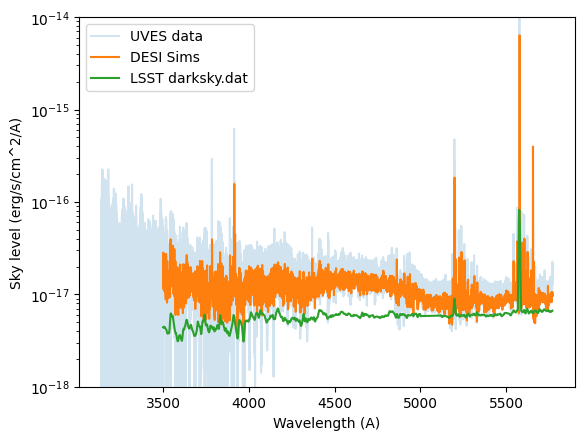

In [39]:
plt.semilogy(uves_sky_wave, uves_sky_flux, label='UVES data', alpha=0.2);
plt.semilogy(sky_wave_u, sky_flux_u, label='DESI Sims');
plt.semilogy(sky_wave_u, lsst_sky(sky_wave_u), label='LSST darksky.dat');
plt.legend()
plt.ylim(1e-18, 1e-14);
plt.xlabel('Wavelength (A)')
plt.ylabel('Sky level (erg/s/cm^2/A)')
plt.savefig('sky.png')

In [40]:
ref_mag = 20.
ref = speclite.filters.ab_reference_flux(sky_wave_u, magnitude=ref_mag)

In [41]:
mbnames = {}
for i in range(7):
    mbnames[i] = ' MB%i' % i
mbnames[7] = '   u'
mbnames[8] = 'CaHK'

In [42]:
# Energy of a photon of wavelength sky_wave_u
wave_ergs = (const.h.cgs * const.c.cgs / sky_wave_u).to('erg')

dwave = np.diff(sky_wave_u)
dwave = np.append(dwave, [dwave[-1]])

tel_area = 1. * u.m**2

ref_photon_rate = ref * dwave * tel_area / wave_ergs
sky_photon_rate = sky_flux_u * dwave * tel_area / wave_ergs

for tel,mbi,thru in combos:
    ref_photons = np.sum(ref_photon_rate * thru(sky_wave_u))
    sky_photons = np.sum(sky_photon_rate * thru(sky_wave_u))
    sky_mag = ref_mag -2.5 * np.log10(sky_photons / ref_photons)
    print('%10s %s: sky brightness is %.2f mag/arcsec^2' % (tel, mbnames[mbi], sky_mag))

   Spec-S5  MB0: sky brightness is 22.02 mag/arcsec^2
   Spec-S5  MB1: sky brightness is 21.77 mag/arcsec^2
   Spec-S5  MB2: sky brightness is 21.61 mag/arcsec^2
   Spec-S5  MB3: sky brightness is 21.41 mag/arcsec^2
   Spec-S5  MB4: sky brightness is 21.56 mag/arcsec^2
   Spec-S5  MB5: sky brightness is 21.67 mag/arcsec^2
   Spec-S5  MB6: sky brightness is 21.59 mag/arcsec^2
      LSST  MB0: sky brightness is 22.01 mag/arcsec^2
      LSST  MB1: sky brightness is 21.77 mag/arcsec^2
      LSST  MB2: sky brightness is 21.61 mag/arcsec^2
      LSST  MB3: sky brightness is 21.41 mag/arcsec^2
      LSST  MB4: sky brightness is 21.56 mag/arcsec^2
      LSST  MB5: sky brightness is 21.67 mag/arcsec^2
      LSST  MB6: sky brightness is 21.59 mag/arcsec^2
       HSC  MB1: sky brightness is 21.77 mag/arcsec^2
       HSC  MB2: sky brightness is 21.61 mag/arcsec^2
       HSC  MB3: sky brightness is 21.41 mag/arcsec^2
       HSC  MB4: sky brightness is 21.56 mag/arcsec^2
     DECam  MB1: sky brightn

In [44]:
srcs = []

limits = np.array(mb_limits)
# Wavelength of the line source...
# For CFHT u and CaH+K, 3950 Ang is pretty much the peak transmission
line_wave = np.append((limits[:-1] + limits[1:]) / 2., [3950.]*2)

for imb,mid in enumerate(line_wave):
    src = np.zeros(len(sky_wave_u))
    i = np.argmin(np.abs(sky_wave_u - mid*u.Angstrom))
    src[i] = (1e-16 / dwave[i].value)
    src = src * sky_flux_u.unit
    srcs.append(src)
    print('Filter %s:' % mbnames[imb], src[i]*dwave[i], 'at %.1f Ang' % mid)

# u band source = MB0
#srcs.append(srcs[0])
# CaH+K source = MB0
#srcs.append(srcs[0])

Filter  MB0: 1e-16 erg / (cm2 s) at 3878.0 Ang
Filter  MB1: 1e-16 erg / (cm2 s) at 4135.5 Ang
Filter  MB2: 1e-16 erg / (cm2 s) at 4392.0 Ang
Filter  MB3: 1e-16 erg / (cm2 s) at 4649.0 Ang
Filter  MB4: 1e-16 erg / (cm2 s) at 4907.5 Ang
Filter  MB5: 1e-16 erg / (cm2 s) at 5166.5 Ang
Filter  MB6: 1e-16 erg / (cm2 s) at 5402.0 Ang
Filter    u: 1e-16 erg / (cm2 s) at 3950.0 Ang
Filter CaHK: 1e-16 erg / (cm2 s) at 3950.0 Ang


In [46]:
ref_photon_rate = ref * dwave * tel_area / wave_ergs

print('For a line source of 1e-16 erg/sec/cm^2 centered in the filter...')
print()

for tel,mbi,thru in combos:
    ref_photons = np.sum(ref_photon_rate * thru(sky_wave_u))
    src_photon_rate = srcs[mbi] * dwave * tel_area / wave_ergs
    src_photons = np.sum(src_photon_rate * thru(sky_wave_u))
    src_mag = ref_mag -2.5 * np.log10(src_photons / ref_photons)
    #print('ref photons:', ref_photons, 'src photons:', src_photons)
    print('%10s %s: source brightness is %.2f mag' % (tel, mbnames[mbi], src_mag))


For a line source of 1e-16 erg/sec/cm^2 centered in the filter...

   Spec-S5  MB0: source brightness is 25.67 mag
   Spec-S5  MB1: source brightness is 25.54 mag
   Spec-S5  MB2: source brightness is 25.39 mag
   Spec-S5  MB3: source brightness is 25.29 mag
   Spec-S5  MB4: source brightness is 25.16 mag
   Spec-S5  MB5: source brightness is 25.06 mag
   Spec-S5  MB6: source brightness is 24.73 mag
      LSST  MB0: source brightness is 25.68 mag
      LSST  MB1: source brightness is 25.54 mag
      LSST  MB2: source brightness is 25.39 mag
      LSST  MB3: source brightness is 25.29 mag
      LSST  MB4: source brightness is 25.16 mag
      LSST  MB5: source brightness is 25.06 mag
      LSST  MB6: source brightness is 24.73 mag
       HSC  MB1: source brightness is 25.54 mag
       HSC  MB2: source brightness is 25.39 mag
       HSC  MB3: source brightness is 25.29 mag
       HSC  MB4: source brightness is 25.16 mag
     DECam  MB1: source brightness is 25.54 mag
     DECam  MB2: sour

In [49]:
psf_exp_times = []
gal_exp_times = []

for tel,mbi,thru in combos:
    pixel_size = pixscales[tel]
    tel_diam = tel_diams[tel]
    seeing = seeings[tel]

    tel_area = (np.pi * (tel_diam / 2.)**2).to('cm^2')
    # from per-arcsec^2 to per-pixel
    sky_photon_rate = sky_flux_u * dwave * tel_area / wave_ergs * pixel_size**2
    sky_photon_rate = np.sum(sky_photon_rate * thru(sky_wave_u))

    # Source spectrum for this filter
    src = srcs[mbi]
    # Total photon count
    src_photon_rate = src * dwave * tel_area / wave_ergs
    src_photon_rate = np.sum(src_photon_rate * thru(sky_wave_u))

    sig = seeing / 2.35 # arcsec
    nea_gal = 4.*np.pi * (sig**2 + (pixel_size**2/12.) + gal_size**2) # in arcsec^2
    nea_psf = 4.*np.pi * sig**2 # arcsec^2

    nea_gal_pix = nea_gal / (pixel_size**2) # in pixels
    nea_psf_pix = nea_psf / (pixel_size**2) # in pixels


    t_galaxy = snr**2 * (sky_photon_rate * nea_gal_pix) / src_photon_rate**2
    t_psf    = snr**2 * (sky_photon_rate * nea_psf_pix) / src_photon_rate**2

    gal_exp_times.append(t_galaxy)
    psf_exp_times.append(t_psf)

    flux = np.sum(src * dwave)
    print('%10s %s: Exp time for Galaxy: %7.1f sec, PSF: %7.1f sec' % (tel, mbnames[mbi], t_galaxy.value, t_psf.value))
         #'  (%s at %.1f A)' % (flux, line_wave[mbi]))

    #print('       src photon rate:', src_photon_rate)
    #print('       sky photon rate per pix:', sky_photon_rate)
    #print('       nea pix: PSF=%.1f, Galaxy=%.1f' % (nea_psf_pix, nea_gal_pix))
    #print('       sky photons: PSF=%.1f, Galaxy=%.1f' % (sky_photon_rate.value * nea_psf_pix, sky_photon_rate.value * nea_gal_pix))

   Spec-S5  MB0: Exp time for Galaxy:  2832.8 sec, PSF:  1916.7 sec
   Spec-S5  MB1: Exp time for Galaxy:  2388.5 sec, PSF:  1616.1 sec
   Spec-S5  MB2: Exp time for Galaxy:  1996.4 sec, PSF:  1350.7 sec
   Spec-S5  MB3: Exp time for Galaxy:  1880.3 sec, PSF:  1272.2 sec
   Spec-S5  MB4: Exp time for Galaxy:  1304.0 sec, PSF:   882.3 sec
   Spec-S5  MB5: Exp time for Galaxy:  1016.8 sec, PSF:   688.0 sec
   Spec-S5  MB6: Exp time for Galaxy:   795.0 sec, PSF:   537.9 sec
      LSST  MB0: Exp time for Galaxy:  3655.3 sec, PSF:  2156.6 sec
      LSST  MB1: Exp time for Galaxy:  2459.4 sec, PSF:  1451.1 sec
      LSST  MB2: Exp time for Galaxy:  1858.4 sec, PSF:  1096.5 sec
      LSST  MB3: Exp time for Galaxy:  1713.7 sec, PSF:  1011.1 sec
      LSST  MB4: Exp time for Galaxy:  1184.8 sec, PSF:   699.0 sec
      LSST  MB5: Exp time for Galaxy:   902.4 sec, PSF:   532.4 sec
      LSST  MB6: Exp time for Galaxy:   679.4 sec, PSF:   400.9 sec
       HSC  MB1: Exp time for Galaxy:  1068.5 se

In [50]:
print('For 10,000 square degrees...')
for (tel,mbi,thru),t_psf,t_gal in zip(combos, psf_exp_times, gal_exp_times):
    fields = 10000 / cam_sqdeg[tel]
    f = fields / 3600. / hrs_per_night
    psf_nights = f * t_psf.value
    gal_nights = f * t_gal.value
    print('%10s %s: PSF: %7.1f nights, Galaxy: %7.1f nights' % (tel, mbnames[mbi], psf_nights, gal_nights))    

For 10,000 square degrees...
   Spec-S5  MB0: PSF:   111.3 nights, Galaxy:   164.5 nights
   Spec-S5  MB1: PSF:    93.8 nights, Galaxy:   138.7 nights
   Spec-S5  MB2: PSF:    78.4 nights, Galaxy:   115.9 nights
   Spec-S5  MB3: PSF:    73.9 nights, Galaxy:   109.2 nights
   Spec-S5  MB4: PSF:    51.2 nights, Galaxy:    75.7 nights
   Spec-S5  MB5: PSF:    39.9 nights, Galaxy:    59.0 nights
   Spec-S5  MB6: PSF:    31.2 nights, Galaxy:    46.2 nights
      LSST  MB0: PSF:    61.2 nights, Galaxy:   103.7 nights
      LSST  MB1: PSF:    41.2 nights, Galaxy:    69.8 nights
      LSST  MB2: PSF:    31.1 nights, Galaxy:    52.7 nights
      LSST  MB3: PSF:    28.7 nights, Galaxy:    48.6 nights
      LSST  MB4: PSF:    19.8 nights, Galaxy:    33.6 nights
      LSST  MB5: PSF:    15.1 nights, Galaxy:    25.6 nights
      LSST  MB6: PSF:    11.4 nights, Galaxy:    19.3 nights
       HSC  MB1: PSF:    75.2 nights, Galaxy:   156.2 nights
       HSC  MB2: PSF:    54.6 nights, Galaxy:   113.4 ni

In [ ]:
# The CFHT Exposure Time Calculator has these numbers:

# CFHT ETC "dark_sky" in e-/s/pixel:
{ 'u' : 0.58, 'g' : 3.34, 'CaHK' : 0.22 }

# "grey sky":
{ 'u' :2.34, 'g' :6.68, 'CaHK':0.45 };